In [306]:
import os
import csv
import json
import random
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 1: Initialization
NUM_SAMPLES = 125
DATASET_DIR = "E:/MyDatasets/hagrid_dataset_512"
ANNOTATIONS_TRAIN = "C:/Users/Ian/git/553.806_Capstone_HandGesture/annotations/train"
LABELS = ['call', 'dislike', 'fist', 'like', 'mute', 'ok', 'one', 'palm', 'peace', 'rock', 'stop', 'stop_inverted']     # 12 gestures: 🤙, 👎, ✊, 👍, 🤐, 👌, ☝, 🖐, ✌, 🤘, ✋, 🤚



def is_point_in_bbox(x, y, bbox, margin=0.01):
    """
    Check if the point (x, y) is within the bounding box.
    """
    tl_x, tl_y, width, height = bbox
    ext_tl_x = tl_x - margin
    ext_tl_y = tl_y - margin
    ext_br_x = tl_x + width + margin
    ext_br_y = tl_y + height + margin
    return ext_tl_x <= x <= ext_br_x and ext_tl_y <= y <= ext_br_y



# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='models/hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

csv_filename = 'keypoint.csv'
with open(csv_filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    
    # STEP 3: Load the input image.
    for label in LABELS:
        with open(os.path.join(ANNOTATIONS_TRAIN, f"{label}.json"), 'r') as file:
            annotations = json.load(file)
        
        samples_cnt = 0
        while samples_cnt < NUM_SAMPLES:
            image_name = random.choice(list(annotations.keys()))
            image_path = os.path.join(DATASET_DIR, label, f'{image_name}.jpg')
            image = mp.Image.create_from_file(image_path)

            # STEP 4: Detect hand landmarks from the input image.
            detection_result = detector.detect(image)

            # STEP 5: Write hand landmark into csv
            annotations_labels = annotations[image_name]['labels']
            annotations_bboxes = annotations[image_name]['bboxes']
            gesture_bboxes = annotations_bboxes[annotations_labels.index(label)]

            label_dict = {label: i for i, label in enumerate(LABELS)}
            for hand_landmarks in detection_result.hand_landmarks:
                row = [label_dict[label]] 
                for landmark in hand_landmarks:
                    if is_point_in_bbox(landmark.x, landmark.y, gesture_bboxes):
                        row.extend([landmark.x, landmark.y, landmark.z])        # may add landmark.z
                
                if len(row) == 64:
                    csvwriter.writerow(row)
                    samples_cnt += 1
        print(f"Writen {samples_cnt} samples of {label}")

print("CSV file has been created:", csv_filename)
                    

Writen 125 sample of call
Writen 125 sample of dislike
Writen 125 sample of fist
Writen 125 sample of like
Writen 125 sample of mute
Writen 125 sample of ok
Writen 125 sample of one
Writen 125 sample of palm
Writen 125 sample of peace
Writen 125 sample of rock
Writen 125 sample of stop
Writen 125 sample of stop_inverted
CSV file has been created: keypoint.csv


In [304]:
import pandas as pd

df = pd.read_csv('keypoint.csv', header=None)
df.iloc[:, 0].value_counts()

0
0     10
1     10
2     10
3     10
4     10
5     10
6     10
7     10
8     10
9     10
10    10
11    10
Name: count, dtype: int64

In [14]:
#@markdown We implemented some functions to visualize the hand landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
 
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

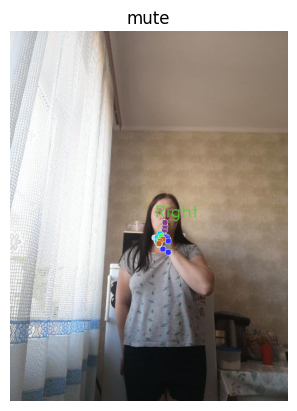

{'bboxes': [[0.5109591, 0.51201953, 0.08226053, 0.0929906]], 'user_id': '78a3b9c9fe8d2fa9ff8cd9646e119f640c305de3823ba86dbe3ba2fb5d414366', 'labels': ['mute']}
[4, 0.5689532160758972, 0.5982339978218079, -9.240472564897573e-08, 0.5489746928215027, 0.5898353457450867, -0.004118239041417837, 0.5364513993263245, 0.5783243775367737, -0.008056950755417347, 0.5275501012802124, 0.5682350397109985, -0.013217264786362648, 0.5209407806396484, 0.5585765838623047, -0.018374476581811905, 0.5564552545547485, 0.5561296343803406, -0.003909443970769644, 0.5564320683479309, 0.5387771129608154, -0.010841870680451393, 0.5568329691886902, 0.5275574326515198, -0.015503260307013988, 0.558552086353302, 0.5182527303695679, -0.018857009708881378, 0.5627316832542419, 0.5573954582214355, -0.006358088459819555, 0.5407626628875732, 0.5487539172172546, -0.017996639013290405, 0.5310320854187012, 0.5584706664085388, -0.0210502278059721, 0.5295090079307556, 0.5683773756027222, -0.02027226984500885, 0.5671870112419128, 

In [294]:
# DEMO
# STEP 1: Import the necessary modules.
import os
import random
import json
import matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='models/hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
label = random.choice(labels)       ######

with open(os.path.join(ANNOTATIONS_TRAIN, f"{label}.json"), 'r') as file:
    annotations = json.load(file)

image_name = random.choice(list(annotations.keys()))    ######

image_path = os.path.join(DATASET_DIR, label, f'{image_name}.jpg')
image = mp.Image.create_from_file(image_path)

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)

# Display the image
plt.imshow(annotated_image)
plt.title(label)
plt.axis('off')  # Hide the axes
plt.show()

print(annotations[image_name])
# print(detection_result.hand_landmarks)


# turn detection_result to landmark
def is_point_in_bbox(x, y, bbox, margin=0.01):
    """
    Check if the point (x, y) is within the bounding box.
    """
    tl_x, tl_y, width, height = bbox
    ext_tl_x = tl_x - margin
    ext_tl_y = tl_y - margin
    ext_br_x = tl_x + width + margin
    ext_br_y = tl_y + height + margin
    return ext_tl_x <= x <= ext_br_x and ext_tl_y <= y <= ext_br_y


# get the box
annotations_labels = annotations[image_name]['labels']
annotations_bboxes = annotations[image_name]['bboxes']
gesture_bboxes = annotations_bboxes[annotations_labels.index(label)]

# Prepare the CSV row
label_dict = {label: i for i, label in enumerate(labels)}
for hand_landmarks in detection_result.hand_landmarks:
    row = [label_dict[label]] 
    for landmark in hand_landmarks:
        if is_point_in_bbox(landmark.x, landmark.y, gesture_bboxes):
            row.extend([landmark.x, landmark.y, landmark.z])        # may add landmark.z
    
    if len(row) == 64:
        print(row)      #####
        # csvwriter.writerow(row)

In [258]:
detection_result

HandLandmarkerResult(handedness=[[Category(index=1, score=0.8976947069168091, display_name='Right', category_name='Right')], [Category(index=0, score=0.994515061378479, display_name='Left', category_name='Left')]], hand_landmarks=[[NormalizedLandmark(x=0.7016859650611877, y=0.4352574944496155, z=1.4952236426779564e-07, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.665172278881073, y=0.4280361533164978, z=-0.01402765978127718, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.6349191069602966, y=0.41098931431770325, z=-0.022112052887678146, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.6154192686080933, y=0.39540451765060425, z=-0.0296236090362072, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5964833498001099, y=0.386496365070343, z=-0.03674685209989548, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.6556516289710999, y=0.36923331022262573, z=-0.008945837616920471, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.6503418684005737, y=0.34271085262

In [234]:
len(row)

41

In [210]:
detection_result.hand_landmarks[0][0]

NormalizedLandmark(x=0.5742834806442261, y=0.5026984214782715, z=-1.6829483362457154e-09, visibility=0.0, presence=0.0)